In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet34, wide_resnet50_2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader_cifar10 = torch.utils.data.DataLoader(trainset_cifar10, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset_cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader_cifar10 = torch.utils.data.DataLoader(testset_cifar10, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:05<00:00, 28985345.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


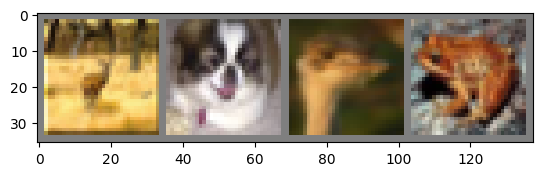

deer  dog   bird  frog 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader_cifar10)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
# net1 = resnet34(weights=None)
# net2 = wide_resnet50_2(weights=None)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])



In [ ]:
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = MobileNet()
    x = torch.randn(1,3,32,32)
    y = net(x)
    print(y.size())

In [ ]:
net1 = ResNet34()
net2 = MobileNet()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.SGD(net1.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(net2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def train_model(trainloader, net, criterion, optimizer, epochs, device):
    net.to(device)
    print_interval = int(len(trainloader)/5)

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % print_interval == print_interval-1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [ ]:
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
train_model(trainloader_cifar10, net1, criterion, optimizer1, epochs, device)

cuda
[1,  2500] loss: 2.491
[1,  5000] loss: 1.969
[1,  7500] loss: 1.706
[1, 10000] loss: 1.493
[1, 12500] loss: 1.344
[2,  2500] loss: 1.186
[2,  5000] loss: 1.145
[2,  7500] loss: 1.052
[2, 10000] loss: 1.009
[2, 12500] loss: 0.954
[3,  2500] loss: 0.840
[3,  5000] loss: 0.790
[3,  7500] loss: 0.808
[3, 10000] loss: 0.775
[3, 12500] loss: 0.764
[4,  2500] loss: 0.625
[4,  5000] loss: 0.620
[4,  7500] loss: 0.619
[4, 10000] loss: 0.602
[4, 12500] loss: 0.627
[5,  2500] loss: 0.464
[5,  5000] loss: 0.497
[5,  7500] loss: 0.491
[5, 10000] loss: 0.483
[5, 12500] loss: 0.511
[6,  2500] loss: 0.334
[6,  5000] loss: 0.365
[6,  7500] loss: 0.395
[6, 10000] loss: 0.388
[6, 12500] loss: 0.392
[7,  2500] loss: 0.256
[7,  5000] loss: 0.265
[7,  7500] loss: 0.275
[7, 10000] loss: 0.308
[7, 12500] loss: 0.308
[8,  2500] loss: 0.176
[8,  5000] loss: 0.216
[8,  7500] loss: 0.213
[8, 10000] loss: 0.231
[8, 12500] loss: 0.241
[9,  2500] loss: 0.125
[9,  5000] loss: 0.141
[9,  7500] loss: 0.164
[9, 10

In [ ]:
print(device)
train_model(trainloader_cifar10, net2, criterion, optimizer2, epochs, device)

cuda
[1,  2500] loss: 2.740
[1,  5000] loss: 2.462
[1,  7500] loss: 2.328
[1, 10000] loss: 2.191
[1, 12500] loss: 2.119
[2,  2500] loss: 2.009
[2,  5000] loss: 1.925
[2,  7500] loss: 1.829
[2, 10000] loss: 1.765
[2, 12500] loss: 1.702
[3,  2500] loss: 1.590
[3,  5000] loss: 1.536
[3,  7500] loss: 1.528
[3, 10000] loss: 1.425
[3, 12500] loss: 1.426
[4,  2500] loss: 1.296
[4,  5000] loss: 1.333
[4,  7500] loss: 1.292
[4, 10000] loss: 1.281
[4, 12500] loss: 1.218
[5,  2500] loss: 1.109
[5,  5000] loss: 1.124
[5,  7500] loss: 1.134
[5, 10000] loss: 1.114
[5, 12500] loss: 1.121
[6,  2500] loss: 0.965
[6,  5000] loss: 0.983
[6,  7500] loss: 0.996
[6, 10000] loss: 1.020
[6, 12500] loss: 1.002
[7,  2500] loss: 0.856
[7,  5000] loss: 0.880
[7,  7500] loss: 0.897
[7, 10000] loss: 0.889
[7, 12500] loss: 0.912
[8,  2500] loss: 0.740
[8,  5000] loss: 0.809
[8,  7500] loss: 0.807
[8, 10000] loss: 0.808
[8, 12500] loss: 0.825
[9,  2500] loss: 0.641
[9,  5000] loss: 0.720
[9,  7500] loss: 0.734
[9, 10

In [ ]:
def test_model(testloader, net, device):

    net.to(device)
    correct = 0
    total = 0
    net.eval()

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = net(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total 
    return acc

In [ ]:
test_model(testloader_cifar10, net1, device)

85.63

In [ ]:
test_model(testloader_cifar10, net2, device)

75.7

In [ ]:
def mutual_learning(trainloader, net1, net2, criterion, optimizer1, optimizer2, epochs, device):
    net1.to(device)
    net2.to(device)
    print_interval = int(len(trainloader)/5)
    # kl_div = nn.KLDivLoss(reduction="sum")

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss1 = 0.0
        running_loss2 = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            # forward + backward + optimize
            outputs1 = net1(inputs)
            # print(outputs1)
            outputs2 = net2(inputs)
            # print(outputs2.shape)
            # print(labels.shape)

            loss1 = criterion(outputs1, labels) + F.kl_div(F.softmax(outputs1, dim = 1), F.softmax(outputs2, dim = 1), reduction = 'sum') # add the kl term for mutual learning
            loss1.backward(retain_graph=True)
            optimizer1.step()

            loss2 = criterion(outputs2, labels) + F.kl_div(F.softmax(outputs2, dim = 1), F.softmax(outputs1, dim = 1), reduction = 'sum') 
            loss2.backward()
            optimizer2.step()

            # print statistics
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()
            if i % print_interval == print_interval-1:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss1: {running_loss1 / 2000:.3f}')
                print(f'[{epoch + 1}, {i + 1:5d}] loss2: {running_loss2 / 2000:.3f}')
                running_loss1 = 0.0
                running_loss2 = 0.0

    print('Finished Training')

In [ ]:
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net1_mul = ResNet34()
net2_mul = MobileNet()
print(device)
optimizer1_mul = optim.SGD(net1_mul.parameters(), lr=0.001, momentum=0.9)
optimizer2_mul = optim.SGD(net2_mul.parameters(), lr=0.001, momentum=0.9)
mutual_learning(trainloader_cifar10, net1_mul, net2_mul, criterion, optimizer1_mul, optimizer2_mul, epochs, device)

cuda
[1,  2500] loss1: -9.206
[1,  2500] loss2: -6.125
[1,  5000] loss1: -9.665
[1,  5000] loss2: -5.217
[1,  7500] loss1: -9.891
[1,  7500] loss2: -4.448


In [ ]:
print('mutual net1')
test_model(testloader_cifar10, net1_mul, device)

85.22

In [ ]:
print('mutual net2')
test_model(testloader_cifar10, net2_mul, device)

76.6